# Statistical Moments - Skewness and Kurtosis | Ways to think about distributions

## Skewness

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

from nsepy import get_history
from datetime import date, datetime, timedelta
import pandas as pd
import seaborn as sns

In [24]:
sns.set()

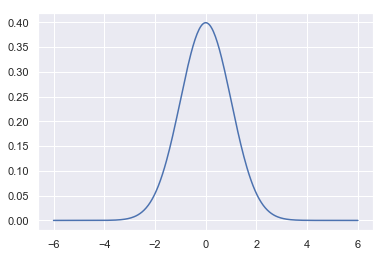

In [25]:
# Plot a normal distribution with mean = 0 and standard deviation = 2
xs = np.linspace(-6,6, 300)
normal = stats.norm.pdf(xs)
plt.plot(xs, normal);

A distribution which is not symmetric is called skewed. 
* A symmetric distribution has skewness 0. 
* Positively skewed unimodal (one mode) distributions have the property that mean > median > mode. 
* Negatively skewed unimodal distributions are the reverse, with mean < median < mode.

All three are equal for a symmetric unimodal distribution.

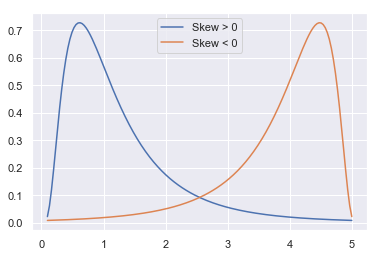

In [26]:
# Generate x-values for which we will plot the distribution
xs2 = np.linspace(stats.lognorm.ppf(0.01, .7, loc=-.1), stats.lognorm.ppf(0.99, .7, loc=-.1), 150)

# Negatively skewed distribution
lognormal = stats.lognorm.pdf(xs2, .7)
plt.plot(xs2, lognormal, label='Skew > 0')

# Positively skewed distribution
plt.plot(xs2, lognormal[::-1], label='Skew < 0')
plt.legend();

For unimodal distributions, a negative skew typically indicates that the tail is fatter on the left, while a positive skew indicates that the tail is fatter on the right.

Although skew is less obvious when graphing discrete data sets, we can still compute it. For example, below are the skew, mean, and median for NIFTY 50 returns 2015-Today. 

Note that the skew is negative, and so the mean is less than the median.

In [27]:
%%time
start = date(2015,1,1)
end = date.today()

nifty_50 = get_history(symbol="NIFTY 50",
                            start=start,
                            end=end,
                            index=True)

display(nifty_50.info())
display(nifty_50.tail())

<class 'pandas.core.frame.DataFrame'>
Index: 1033 entries, 2015-01-01 to 2019-03-01
Data columns (total 6 columns):
Open        1033 non-null float64
High        1033 non-null float64
Low         1033 non-null float64
Close       1033 non-null float64
Volume      1033 non-null int64
Turnover    1033 non-null float64
dtypes: float64(5), int64(1)
memory usage: 56.5+ KB


None

,Open,High,Low,Close,Volume,Turnover
Date,,,,,,
2019-02-25,10813.25,10887.10,10788.05,10880.10,385905142,1.646609e+11
2019-02-26,10775.30,10888.75,10729.30,10835.30,414954476,1.918675e+11
2019-02-27,10881.20,10939.70,10751.20,10806.65,381080073,1.831385e+11
2019-02-28,10865.70,10865.70,10784.85,10792.50,644159018,2.712334e+11
2019-03-01,10842.65,10877.90,10823.10,10863.50,308526309,1.501006e+11


CPU times: user 1.18 s, sys: 212 ms, total: 1.39 s
Wall time: 1.23 s


Skew: -0.5170300312030655
Mean: 0.000298805872490214
Median: 0.0003384157616015404


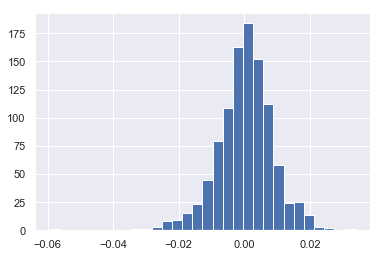

In [28]:
pricing = nifty_50['Close']
returns = pricing.pct_change()[1:]

print('Skew:', stats.skew(returns))
print('Mean:', np.mean(returns))
print('Median:', np.median(returns))

plt.hist(returns, 30);

## Kurtosis

Kurtosis attempts to measure the shape of the deviation from the mean. Generally, it describes how peaked a distribution is compared the the normal distribution, called mesokurtic.

All normal distributions, regardless of mean and variance, have a kurtosis of $3$. A leptokurtic distribution ($kurtosis > 3$) is highly peaked and has fat tails, while a platykurtic distribution ($kurtosis < 3$) is broad. 

Sometimes, however, kurtosis in excess of the normal distribution ($kurtosis - 3$) is used, and this is the default in `scipy`.

A leptokurtic distribution has more frequent large jumps away from the mean than a normal distribution does while a platykurtic distribution has fewer.

Excess kurtosis of leptokurtic distribution: 3.0
Excess kurtosis of mesokurtic distribution: 0.0
Excess kurtosis of platykurtic distribution: -0.5937628755982794


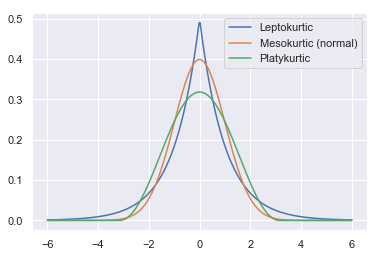

In [30]:
# Plot some example distributions
plt.plot(xs,stats.laplace.pdf(xs), label='Leptokurtic')
print('Excess kurtosis of leptokurtic distribution:', (stats.laplace.stats(moments='k')))
plt.plot(xs, normal, label='Mesokurtic (normal)')
print('Excess kurtosis of mesokurtic distribution:', (stats.norm.stats(moments='k')))
plt.plot(xs,stats.cosine.pdf(xs), label='Platykurtic')
print('Excess kurtosis of platykurtic distribution:', (stats.cosine.stats(moments='k')))
plt.legend();

To find the excess kurtosis of the NIFTY 50 returns from before.

In [31]:
print("Excess kurtosis of returns: ", stats.kurtosis(returns))

Excess kurtosis of returns:  3.0370718801328263


The histogram of the returns shows significant observations beyond 3 standard deviations away from the mean, multiple large spikes, so we shouldn't be surprised that the kurtosis is indicating a leptokurtic distribution.

## Normality Testing Using Jarque-Bera

The Jarque-Bera test is a common statistical test that compares whether sample data has skewness and kurtosis similar to a normal distribution. 

The Jarque Bera test's null hypothesis is that the data came from a normal distribution. Because of this it can err on the side of not catching a non-normal process if you have a low p-value. To be safe it can be good to increase your cutoff when using the test.

Remember to treat p-values as binary and not try to read into them or compare them. We'll use a cutoff of 0.05 for our p-value.

### Test calibration

It is often a good idea to calibrate a test by checking it on simulated data and making sure it gives the right answer. Let's do that now.

In [32]:
from statsmodels.stats.stattools import jarque_bera

N = 1000
M = 1000

pvalues = np.ndarray((N))

for i in range(N):
    # Draw M samples from a normal distribution 
    X = np.random.normal(0, 1, M);
    _, pvalue, _, _ = jarque_bera(X)
    pvalues[i] = pvalue
    
# count number of pvalues below our default 0.05 cutoff
num_significant = len(pvalues[pvalues < 0.05])

print (float(num_significant) / N)

0.045


Great, if properly calibrated we should expect to be wrong  5%  of the time at a 0.05 significance level, and this is pretty close. This means that the test is working as we expect.

In [34]:
_, pvalue, _, _ = jarque_bera(returns)

if pvalue > 0.05:
    print('The returns are likely normal.')
else:
    print('The returns are likely not normal.')

The returns are likely not normal.


This tells us that the NIFTY 50 returns likely do not follow a normal distribution.